# Imaging Tutorials

## Step 1: Input & setup

In [2]:
import subprocess
# import multiprocess
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import wcs
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.visualization import make_lupton_rgb
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.style.use("default")
plt.rc('xtick', direction='in', top=True)
plt.rc('ytick', direction='in', right=True)
plt.rc('axes', linewidth=1.15)

plt.rc("mathtext", fontset="dejavuserif")

In [4]:
if not os.path.exists('../Data/Images'):
    os.system('mkdir ../Data/Images')

if not os.path.exists('../Data/Images/RGB'):
    os.system('mkdir ../Data/Images/RGB')

event_file = '../Data/Filtered_data/Merged/Merged_020_s05_TM0_Events.fits'

In [5]:
band_min = 200
band_max = 2300

## Step 2: Creating Image and exposure map

In [6]:
def run_evtool(input_name, output_name, emin, emax, gti_type='FLAREGTI', flag_type='0xe00fff30', size='auto', pattern='15', telid='1 2 3 4 5 6 7', log_file=None):
    subprocess.run(['evtool', 
                    f'eventfiles={input_name}', 
                    f'outfile={output_name}', 
                    f'gti={gti_type}', 
                    f'flag={flag_type}', 
                    f'pattern={pattern}', 
                    f'emin={emin}', 
                    f'emax={emax}',
                    f'image=yes',
                    f'events=yes',
                    f'telid={telid}',
                    f'size={size}'
                    ],
                    stdout=log_file,
                    stderr=log_file)
    
def run_expmap(input_eventlist, input_image, output_name, emin, emax, log_file=None):
    subprocess.run(['expmap', 
                    f'inputdatasets={input_eventlist}', 
                    f'templateimage={input_image}', 
                    f'mergedmaps={output_name}', 
                    f'emin={emin}', 
                    f'emax={emax}',
                    'withvignetting=yes',
                    'withweights=yes',
                    ],
                    stdout=log_file,
                    stderr=log_file)

In [7]:
run_evtool(event_file, f'../Data/Images/merged_image_{int(band_min)}_{int(band_max)}.fits', 
           band_min/1000, band_max/1000, log_file=open(f'../Data/Images/merged_image_{int(band_min)}_{int(band_max)}.log', 'w+'))

run_expmap(event_file, f'../Data/Images/merged_image_{int(band_min)}_{int(band_max)}.fits', 
           f'../Data/Images/merged_expmap_{int(band_min)}_{int(band_max)}.fits', 
           band_min/1000, band_max/1000, log_file=open(f'../Data/Images/merged_expmap_{int(band_min)}_{int(band_max)}.log', 'w+'))

## Step 3: Exposure correction

In [1]:
def exp_corr(input_image, input_expmap, output_name):
    cts = fits.open(input_image)[0].data
    exp = fits.open(input_expmap)[0].data
    hdr = fits.getheader(input_image)

    exp_corr = cts/exp

    fits.writeto(output_name, exp_corr, header=hdr, overwrite=True)

In [8]:
exp_corr(f'../Data/Images/merged_image_{int(band_min)}_{int(band_max)}.fits',
         f'../Data/Images/merged_expmap_{int(band_min)}_{int(band_max)}.fits',
         f'../Data/Images/merged_exp_corr_{int(band_min)}_{int(band_max)}.fits')

## Step 4: Viewing the image

In [5]:
image = fits.open(f'../Data/Images/merged_exp_corr_{int(band_min)}_{int(band_max)}.fits')[0]
image_wcs = wcs.WCS(image.header)

In [68]:
def plot_image(image, image_wcs, ra_l=None, ra_u=None, dec_l=None, dec_u=None, vmin=0, vmax=1, sigma=2, smooth=True, limits=True, cmap='viridis'):
    fig = plt.figure(1, figsize=(6, 6))
    ax = plt.subplot(projection=image_wcs)

    if smooth:
        smoothed_image = gaussian_filter(image.data, sigma=sigma)
        im = ax.imshow(smoothed_image, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    else:
        im = ax.imshow(image.data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)

    ra_ax = ax.coords[0]
    ra_ax.set_format_unit(unit='degree')

    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    
    if limits:
        if ra_l is not None and ra_u is not None and dec_l is not None and dec_u is not None:
            ra_u, dec_u = image_wcs.all_world2pix(ra_u, dec_u, 0)
            ra_l, dec_l = image_wcs.all_world2pix(ra_l, dec_l, 0)
            ax.set_xlim(ra_u, ra_l)
            ax.set_ylim(dec_l, dec_u)
        else:
            raise ValueError("ra_l, ra_u, dec_l, and dec_u must be provided when limits=True")
    
    ax.grid(color='white', lw=1, ls='--', alpha=0.5)

    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Counts')

In [7]:
def get_ra_dec_range(image_data, image_wcs):
    ny, nx = image_data.shape
    corners = [[0, 0], [0, ny], [nx, 0], [nx, ny]]
    world_coords = image_wcs.all_pix2world(corners, 0)
    ra_values = world_coords[:, 0]
    dec_values = world_coords[:, 1]
    ra_min, ra_max = ra_values.min(), ra_values.max()
    dec_min, dec_max = dec_values.min(), dec_values.max()

    data_max = np.max(image_data)
    data_min = np.min(image_data)

    return ra_min, ra_max, dec_min, dec_max, data_min, data_max

# ra_min, ra_max, dec_min, dec_max, data_min, data_max = get_ra_dec_range(image.data, image_wcs)

In [8]:
import ipywidgets as widgets
from ipywidgets import interact
import io
from ipywidgets import FileUpload, VBox, Output

In [80]:
output = Output()

image = None
image_wcs = None

def file_upload(change):
    global image, image_wcs, ra_min, ra_max, dec_min, dec_max, data_min, data_max

    with output:
        output.clear_output()
        
        uploaded_file = list(change['new'].values())[0]
        file_content = uploaded_file['content']

        file_like = io.BytesIO(file_content)
        
        with fits.open(file_like) as hdulist:
            image = hdulist[0].data
            image_wcs = wcs.WCS(hdulist[0].header)

            v_slider.min = -1e6
            v_slider.value = [-1e6, 1e6]
            ra_min, ra_max, dec_min, dec_max, data_min, data_max = get_ra_dec_range(image, image_wcs)
            v_slider.max = data_max
            v_slider.min = data_min
            v_slider.value = [data_min, data_max * 0.8]
            ra_slider.max = ra_max
            ra_slider.min = ra_min
            ra_slider.value = [ra_min, ra_max]
            dec_slider.max = dec_max
            dec_slider.min = dec_min
            dec_slider.value = [dec_min, dec_max]

file_selector = widgets.FileUpload(accept='.fits', multiple=False)
file_selector.observe(file_upload, names='value')

def interactive_plot(v_range, ra_range, dec_range, sigma):
    if image is None or image_wcs is None:
        print("No input provided")
        return
    
    vmin, vmax = v_range
    ra_l, ra_u = ra_range
    dec_l, dec_u = dec_range
    plot_image(image, image_wcs, ra_l, ra_u, dec_l, dec_u, vmin, vmax, sigma=sigma, limits=True)

v_slider = widgets.FloatRangeSlider(description='vmin/vmax', layout=widgets.Layout(width='500px'), readout_format='.1f')
ra_slider = widgets.FloatRangeSlider(description='RA range', layout=widgets.Layout(width='500px'), readout_format='.1f')
dec_slider = widgets.FloatRangeSlider(description='Dec range', layout=widgets.Layout(width='500px'), readout_format='.1f')
sigma_slider = widgets.FloatSlider(value=2, min=0, max=5, step=0.5, description='Sigma', layout=widgets.Layout(width='500px'),readout_format='.1f')

display(VBox([widgets.Label("Upload a .fits file:"), file_selector, output]))
interact(interactive_plot, v_range=v_slider, ra_range=ra_slider, dec_range=dec_slider, sigma=sigma_slider)


interactive(children=(FloatRangeSlider(value=(25.0, 75.0), description='vmin/vmax', layout=Layout(width='500px…

<function __main__.interactive_plot(v_range, ra_range, dec_range, sigma)>

## Step 5: RGB image

In [9]:
bands = [(200,700), (700, 1100), (1100, 2300)]

In [11]:
from concurrent.futures import ProcessPoolExecutor

log_file_path = '../Data/Images/RGB/merged_image_RGB.log'
with open(log_file_path, 'w+') as log_file:
    pass

def process_band(band):
    output_image = f'../Data/Images/RGB/merged_image_{band[0]}_{band[1]}.fits'
    output_expmap = f'../Data/Images/RGB/merged_expmap_{band[0]}_{band[1]}.fits'
    output_exp_corr = f'../Data/Images/RGB/merged_exp_corr_{band[0]}_{band[1]}.fits'
    
    with open(log_file_path, 'a') as log_file:
        run_evtool(event_file, output_image, band[0]/1000, band[1]/1000, log_file=log_file)
        run_expmap(event_file, output_image, output_expmap, band[0]/1000, band[1]/1000, log_file=log_file)
        exp_corr(output_image, output_expmap, output_exp_corr)

with ProcessPoolExecutor() as executor:
    executor.map(process_band, bands)

with open(log_file_path, 'r') as log_file:
    log_content = log_file.readlines()
    evtool_count = sum(1 for line in log_content if 'evtool: DONE' in line)
    expmap_count = sum(1 for line in log_content if 'expmap: DONE' in line)
    if evtool_count == 3 and expmap_count == 3:
        print("All evtool and expmap tasks completed successfully")

All evtool and expmap tasks completed successfully


In [56]:
exp_corr = [fits.open(f'../Data/Images/RGB/merged_exp_corr_{band[0]}_{band[1]}.fits')[0].data for band in bands]
image_wcs = wcs.WCS(fits.open(f'../Data/Images/RGB/merged_exp_corr_{bands[0][0]}_{bands[0][1]}.fits')[0].header)

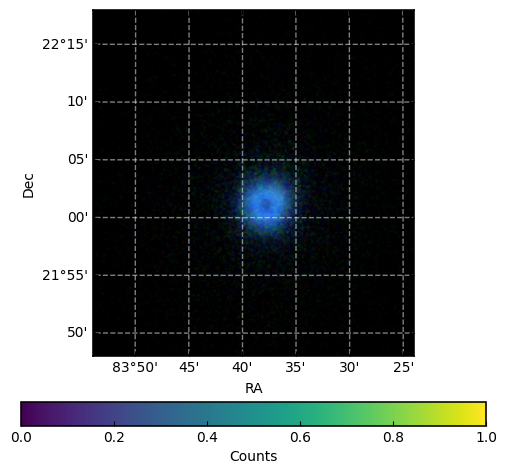

In [84]:
kern = Gaussian2DKernel(1)
smo = [convolve_fft(r,
                    kern,
                    boundary='wrap',
                    normalize_kernel=True,
                    ) for r in exp_corr]

smo_rgb = make_lupton_rgb(smo[0],smo[1],smo[2],
                          minimum=1e-4,
                          stretch=0.1,
                          )

plot_image(smo_rgb, image_wcs, 83.4, 83.9, 21.8, 22.3, smooth=False, sigma=0, cmap=None)

### Step 5.1: Optional sliders for RGB Images

In [61]:
ra_min, ra_max, dec_min, dec_max, data_min, data_max = get_ra_dec_range(exp_corr[0], image_wcs)

In [72]:
def interactive_RGB_plot(v_range, ra_range, dec_range, sigma):
    vmin, vmax = v_range
    ra_l, ra_u = ra_range
    dec_l, dec_u = dec_range
    plot_image(smo_rgb, image_wcs, ra_l, ra_u, dec_l, dec_u, vmin, vmax, sigma=sigma, limits=True, cmap='viridis')

v_slider = widgets.FloatRangeSlider(value=[0, 0.8], min=data_min, max=data_max ,description='vmin/vmax', layout=widgets.Layout(width='500px'), readout_format='.1f')
ra_slider = widgets.FloatRangeSlider(value=[ra_min, ra_max], min=ra_min, max=ra_max, description='RA range', layout=widgets.Layout(width='500px'), readout_format='.1f')
dec_slider = widgets.FloatRangeSlider(value=[dec_min, dec_max], min=dec_min, max=dec_max,description='Dec range', layout=widgets.Layout(width='500px'), readout_format='.1f')
sigma_slider = widgets.FloatSlider(value=2, min=0, max=5, step=0.5, description='Sigma', layout=widgets.Layout(width='500px'),readout_format='.1f')

interact(interactive_RGB_plot, v_range=v_slider, ra_range=ra_slider, dec_range=dec_slider, sigma=sigma_slider)

interactive(children=(FloatRangeSlider(value=(0.0, 0.32734480635794416), description='vmin/vmax', layout=Layou…

<function __main__.interactive_RGB_plot(v_range, ra_range, dec_range, sigma)>